Homework 6 | CNN 2D | Ruchi Manikrao Dhore | W1652116

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

In [5]:
class Layer:
    def __init__(self, trainable=True):
        self.trainable = trainable

    def forward(self, inputs):
        raise NotImplementedError

    def backward(self, grad):
        raise NotImplementedError

    def update_params(self, learning_rate):
        pass

    def set_trainable(self, trainable):
        self.trainable = trainable


In [6]:
class Flatten(Layer):
    def __init__(self):
        super().__init__()

    def forward(self, inputs):
        self.batch_size = inputs.shape[0]
        self.in_shape = inputs.shape[1:]
        return inputs.reshape(self.batch_size, -1)

    def backward(self, grad):
        return grad.reshape(self.batch_size, *self.in_shape)


In [7]:
class Dense(Layer):
    def __init__(self, in_size, op_size):
        super().__init__()
        self.wts = np.random.randn(in_size, op_size) * np.sqrt(2.0 / (in_size + op_size))
        self.biases = np.zeros(op_size)
        self.learning_rate = None

    def forward(self, inputs):
        self.inputs = inputs
        return np.dot(inputs, self.wts) + self.biases

    def backward(self, grad):
        grad_inputs = np.dot(grad, self.wts.T)
        grad_wts = np.dot(self.inputs.T, grad)
        grad_biases = np.sum(grad, axis=0)
        self.wts -= self.learning_rate * grad_wts
        self.biases -= self.learning_rate * grad_biases
        return grad_inputs

    def update_params(self, learning_rate):
        self.learning_rate = learning_rate


In [8]:
class ReLU(Layer):
    def __init__(self):
        super().__init__()

    def forward(self, inputs):
        self.inputs = inputs
        return np.maximum(0, inputs)

    def backward(self, grad_outputs):
        grad_inputs = np.array(grad_outputs, copy=True)
        grad_inputs[self.ips <= 0] = 0
        return grad_inputs


In [9]:
class Softmax(Layer):
    def __init__(self):
        super().__init__()

    def forward(self, inputs):
        exp_inputs = np.exp(inputs - np.max(inputs, axis=-1, keepdims=True))
        softmax = exp_inputs / np.sum(exp_inputs, axis=-1, keepdims=True)
        self.softmax = softmax
        return softmax

    def backward(self, grad_outputs):
        dot_product = np.sum(self.softmax * grad_outputs, axis=-1, keepdims=True)
        grad_inputs = self.softmax * (grad_outputs - dot_product)
        return grad_inputs


In [10]:
class Model:
  def init(self, layers):
      self.layers = layers

  def forward(self, inputs):
      for layer in self.layers:
          inputs = layer.forward(inputs)
      return inputs

  def backward(self, grad_output):
      for layer in reversed(self.layers):
          grad_output = layer.backward(grad_output)

  def update_params(self, learning_rate):
      for layer in self.layers:
          if isinstance(layer, TrainableLayer):
              layer.update_params(learning_rate)

  def get_params(self):
      params_list = []
      for layer in self.layers:
         if isinstance(layer, TrainableLayer):
              params_list.append(layer.get_params())
      return params_list


In [11]:
class conv2d_CV:
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        
        # To initialize the filter bank weights randomly
        self.weights = np.random.randn(out_channels, in_channels, kernel_size, kernel_size)

    def forward(self, inputs):
        batch_size, in_height, in_width, in_channels = inputs.shape
        out_height = ((in_height + 2*self.padding - self.kernel_size) // self.stride) + 1
        out_width = ((in_width + 2*self.padding - self.kernel_size) // self.stride) + 1
        outputs = np.zeros((batch_size, out_height, out_width, self.out_channels))
        padded_inputs = np.pad(inputs, ((0, 0), (self.padding, self.padding), (self.padding, self.padding), (0, 0)), mode='constant')
        
        for h_out in range(out_height):
            for w_out in range(out_width):
                h_start = h_out * self.stride
                w_start = w_out * self.stride
                h_end = h_start + self.kernel_size
                w_end = w_start + self.kernel_size
                window = padded_inputs[:, h_start:h_end, w_start:w_end, :]
                for c_out in range(self.out_channels):
                    outputs[:, h_out, w_out, c_out] = np.sum(window * self.weights[c_out, :, :, :], axis=(1, 2, 3))
        return outputs

    def backward(self, inputs, grad_op, learning_rate):
        batch_size, in_height, in_width, in_channels = inputs.shape
        _, out_height, out_width, out_channels = grad_op.shape
        padded_inputs = np.pad(inputs, ((0, 0), (self.padding, self.padding), (self.padding, self.padding), (0, 0)), mode='constant')
        padded_grad_ip = np.zeros_like(padded_inputs)
        grad_weights = np.zeros_like(self.weights)
        
        for h_out in range(out_height):
            for w_out in range(out_width):
                h_start = h_out * self.stride
                w_start = w_out * self.stride
                h_end = h_start + self.kernel_size
                w_end = w_start + self.kernel_size
                window = padded_inputs[:, h_start:h_end, w_start:w_end, :]
                for c_out in range(out_channels):
                    grad_weights[c_out, :, :, :] += np.sum(
                        window * grad_op[:, h_out, w_out, c_out][:, None, None, None], axis=0)
                for b in range(batch_size):
                    padded_grad_ip[b, h_start:h_end, w_start:w_end, :] += np.sum((self.weights[:, :, :, :] * grad_op[b, h_out, w_out, :][:, None, None, None]), axis=0)

        # To remove padding
        grad_in = padded_grad_ip[:, self.padding:-self.padding, self.padding:-self.padding, :]

        # To update weights
        self.weights -= learning_rate * grad_weights / batch_size

        return grad_in


In [12]:
class max_pool_2d_CV:
    def __init__(self, pool_size, stride=1):
        self.pool_size = pool_size
        self.stride = stride
        
    def forward(self, X):
        batch_size, in_height, in_width, in_channels = X.shape
        out_height = int(((in_height - self.pool_size) / self.stride) + 1)
        out_width = int(((in_width - self.pool_size) / self.stride) + 1)
        out = np.zeros((batch_size, out_height, out_width, in_channels))
        
        for h in range(out_height):
            for w in range(out_width):
                h_start = h * self.stride
                w_start = w * self.stride
                h_end = h_start + self.pool_size
                w_end = w_start + self.pool_size
                window = X[:, h_start:h_end, w_start:w_end, :]
                out[:, h, w, :] = np.max(window, axis=(1, 2))
        return out
    
    def backward(self, X, grad_op):
        batch_size, in_height, in_width, in_channels = X.shape
        _, out_height, out_width, _ = grad_op.shape
        grad_in = np.zeros_like(X)
        
        for h in range(out_height):
            for w in range(out_width):
                h_start = h * self.stride
                w_start = w * self.stride
                h_end = h_start + self.pool_size
                w_end = w_start + self.pool_size
                window = X[:, h_start:h_end, w_start:w_end, :]
                grad_pool = grad_op[:, h, w, :, None, None]
                grad_mask = (window == np.max(window, axis=(1, 2))[:, None, None, :])
                grad_in[:, h_start:h_end, w_start:w_end, :] += grad_pool * grad_mask
        return grad_in


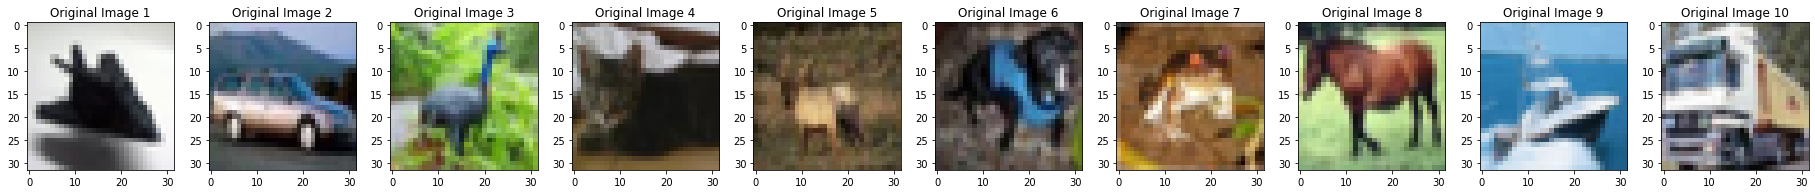

In [14]:
input_range = 10

# To store images from cifar10 10 classes
input_image_dataset = []

# To load the CIFAR-10 dataset
(x_train, y_train), (X_test, y_test) = cifar10.load_data()

# To get the first image from every class in the training set
for i in range(input_range):
  first_image_index = next((index for index, label in enumerate(y_train) if label[0] == i), None)
  input_image_dataset.append(x_train[first_image_index])

# To plot original images
figure = plt.figure(figsize = (32, 32))
figure.tight_layout()

for i in range(input_range):
  plt.subplot(10, 10, i + 1)
  plt.imshow(input_image_dataset[i])
  plt.title("Original Image " + str(i+1))

# To normalize pixel values between 0 and 1
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

# To convert class labels to one-hot encoded vectors
num_classes = 10
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

# To define the model architecture
model = [
    conv2d_CV(in_channels=1, out_channels=32, kernel_size=3, padding=1),
    max_pool_2d_CV(pool_size=2, stride=2),
    conv2d_CV(in_channels=32, out_channels=64, kernel_size=3, padding=1),
    max_pool_2d_CV(pool_size=2, stride=2),
    Flatten(),
    Dense(7*7*64, 128),
    ReLU(),
    Dense(128, 10),
    Softmax()
]


In [15]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Flatten, Dense, ReLU, Softmax
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import SGD

class Model:
    def __init__(self, layers):
        self.layers = layers

    def forward(self, inputs):
        for layer in self.layers:
            inputs = layer.forward(inputs)
        return inputs

    def backward(self, grads):
        for layer in reversed(self.layers):
            grads = layer.backward(grads)
        return grads

class Conv2DLayer:
    def __init__(self, filter_shape, num_filters, stride=1, padding='VALID'):
        self.filter_shape = filter_shape
        self.num_filters = num_filters
        self.stride = stride
        self.padding = padding
        self.filters = np.random.randn(filter_shape[0], filter_shape[1], filter_shape[2], num_filters)

    def forward(self, inputs):
        self.inputs = inputs
        batch_size, in_height, in_width, input_channels = inputs.shape
        op_height = int((in_height - self.filter_shape[0]) / self.stride) + 1
        op_width = int((in_width - self.filter_shape[1]) / self.stride) + 1
        self.outputs = np.zeros((batch_size, op_height, op_width, self.num_filters))
        for i in range(op_height):
            for j in range(op_width):
                receptive_field = inputs[:, i * self.stride:i * self.stride + self.filter_shape[0],
                                          j * self.stride:j * self.stride + self.filter_shape[1], :]
                for k in range(self.num_filters):
                    self.outputs[:, i, j, k] = np.sum(receptive_field * self.filters[:, :, :, k], axis=(1, 2, 3))
        return self.outputs

    def backward(self, grads):
        batch_size, in_height, ip_width, input_channels = self.inputs.shape
        op_height, op_width, op_channels = grads.shape
        delta = np.zeros_like(self.inputs)
        delta_filters = np.zeros_like(self.filters)
        for i in range(op_height):
            for j in range(op_width):
                receptive_field = self.inputs[:, i * self.stride:i * self.stride + self.filter_shape[0],
                                          j * self.stride:j * self.stride + self.filter_shape[1], :]
                for k in range(op_channels):
                    delta[:, i * self.stride:i * self.stride + self.filter_shape[0],
                          j * self.stride:j * self.stride + self.filter_shape[1], :] += (
                            grads[:, i, j, k] * self.filters[:, :, :, k][None, :, :, :])
                    delta_filters[:, :, :, k] += np.sum(
                        receptive_field * grads[:, i, j, k][:, None, None, None], axis=0)
        self.filters -= delta_filters * 0.01
        return delta

class ReLU:
    def forward(self, inputs):
        self.inputs = inputs
        return np.maximum(0, inputs)

    def backward(self, grads):
        grads[self.inputs <= 0] = 0
        return grads


In [16]:
class Dense:
    def __init__(self, in_size, op_size):
        self.weights = np.random.randn(in_size, op_size)
        self.bias = np.zeros(op_size)

    def forward(self, inputs):
        # To compute the output of the dense layer
        outputs = np.dot(inputs, self.weights) + self.bias
        return outputs


In [17]:
def train(model, train_dataset, num_epochs, learning_rate):
    # To define loss function and optimizer
    loss_fn = CategoricalCrossentropy()
    optimizer = SGD(learning_rate=learning_rate)

    # To create empty lists to store loss and filter history
    loss_history = []
    filter_history = []

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        num_batches = 0
        for images, labels in train_dataset:
            with tf.GradientTape() as tape:
                # The forward pass
                logits = model(images)

                # To compute loss
                loss_value = loss_fn(labels, logits)

            # The backward pass
            gradients = tape.gradient(loss_value, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))

            epoch_loss += loss_value.numpy()
            num_batches += 1

        avg_loss = epoch_loss / num_batches
        loss_history.append(avg_loss)

        # To record filter weights every epoch
        filter_history.append(model.conv1.get_weights()[0])
        print("Epoch {} loss = {}".format(epoch+1, avg_loss))

    return loss_history, filter_history


In [18]:
@tf.function
def train_step(model, images, labels, loss_fn, optimizer):
    with tf.GradientTape() as tape:
        # To make a prediction on all the batch
        logits = model(images, training=True)
        # To remove the extra dimension from labels
        labels = tf.squeeze(labels)
        # To compute loss
        loss = loss_fn(labels, logits)

    # To compute gradients
    gradients = tape.gradient(loss, model.trainable_variables)
    # To update weights
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    # To compute the accuracy
    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(logits, axis=1), tf.argmax(labels, axis=1)), tf.float32))

    return loss, accuracy


Epoch 1 Loss 1.888777494430542
Epoch 2 Loss 1.7089910507202148
Epoch 3 Loss 1.6316401958465576
Epoch 4 Loss 1.585045576095581
Epoch 5 Loss 1.5471593141555786
Epoch 6 Loss 1.5150859355926514
Epoch 7 Loss 1.489723563194275
Epoch 8 Loss 1.4644185304641724
Epoch 9 Loss 1.4439096450805664
Epoch 10 Loss 1.4241867065429688
Epoch 11 Loss 1.406956434249878
Epoch 12 Loss 1.3904600143432617
Epoch 13 Loss 1.3747990131378174
Epoch 14 Loss 1.362034559249878
Epoch 15 Loss 1.347988486289978
Epoch 16 Loss 1.3368834257125854
Epoch 17 Loss 1.3254207372665405
Epoch 18 Loss 1.312515139579773
Epoch 19 Loss 1.3026683330535889
Epoch 20 Loss 1.2920176982879639


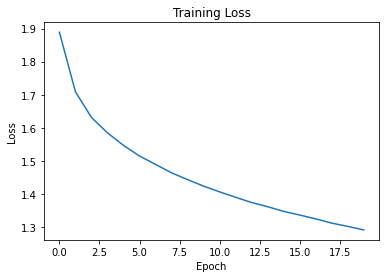

In [19]:
import tensorflow as tf
from tensorflow import keras
from keras.datasets import cifar10
import matplotlib.pyplot as plt

# To define the model
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(32, 32, 3)),
    keras.layers.Dense(132, activation='relu'),
    keras.layers.Dense(10)])

# To define the optimizer and loss function
optimizer = keras.optimizers.SGD(learning_rate=0.01)
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# To define the training step
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        logits = model(images, training=True)
        loss = loss_fn(labels, logits)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

# To define the training loop
def train(model, dataset, num_epochs, learning_rate):
    loss_history = []
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for step, (images, labels) in enumerate(dataset):
            loss = train_step(images, labels)
            epoch_loss += loss
        loss_history.append(epoch_loss/(step+1))
        print('Epoch {} Loss {}'.format(epoch+1, loss_history[-1]))

    return loss_history

# To load the CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# To normalize pixel values between 0 and 1
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# To create the train dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=3072).batch(32)

# To train the model for 20 epochs
loss_history = train(model, train_dataset, num_epochs=20, learning_rate=0.01)

# To plot the training loss curve
plt.plot(loss_history)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


Epoch 1 loss = 0.9496240615844727
Epoch 2 loss = 0.9443148374557495
Epoch 3 loss = 0.9398636817932129
Epoch 4 loss = 0.9353969097137451
Epoch 5 loss = 0.9312469959259033
Epoch 6 loss = 0.9289243817329407
Epoch 7 loss = 0.9197749495506287
Epoch 8 loss = 0.9226004481315613
Epoch 9 loss = 0.9159222841262817
Epoch 10 loss = 0.9102534651756287
Epoch 11 loss = 0.9073838591575623
Epoch 12 loss = 0.9057956337928772
Epoch 13 loss = 0.9010905623435974
Epoch 14 loss = 0.8977513313293457
Epoch 15 loss = 0.8916416168212891
Epoch 16 loss = 0.8859269618988037
Epoch 17 loss = 0.8828734159469604
Epoch 18 loss = 0.8793366551399231
Epoch 19 loss = 0.8794176578521729
Epoch 20 loss = 0.8721895813941956


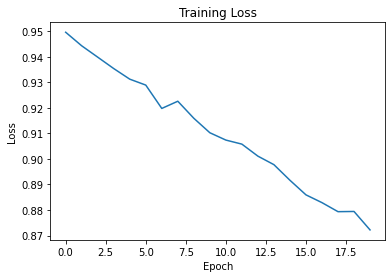

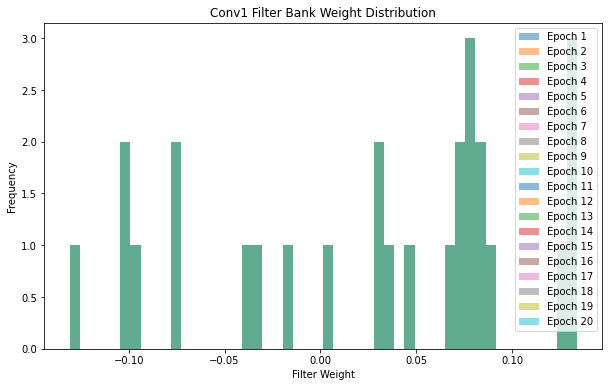

In [24]:
# To define the model
model = keras.Sequential([
    keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(32,32,3)),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(132, activation='relu'),
    keras.layers.Dense(10)
])

def train(model, dataset, num_epochs, learning_rate):
    loss_history = []
    filter_history = []
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        num_batches = 0
        for step, (images, labels) in enumerate(dataset):
            loss = train_step(images, labels)
            epoch_loss += loss
            num_batches += 1
        loss_history.append(epoch_loss/(step+1))
        avg_loss = epoch_loss / num_batches

        # To record filter weights every epoch
        filter_history.append(model.layers[0].get_weights()[0])
        print("Epoch {} loss = {}".format(epoch+1, avg_loss))
    return loss_history, filter_history

# To load the CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# To normalize pixel values between 0 and 1
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# To create the train dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(32)

# To train the model for 20 epochs
loss_history, filter_history = train(model, train_dataset, num_epochs=20, learning_rate=0.01)

# To plot the training loss curve
plt.plot(loss_history)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Plot the filter bank weight distribution for the second convolutional layer
plt.figure(figsize=(10, 6))
for epoch, filters in enumerate(filter_history):
    plt.hist(filters[:, :, :, 0].flatten(), bins=50, alpha=0.5, label=f"Epoch {epoch+1}")
plt.legend()
plt.xlabel("Filter Weight")
plt.ylabel("Frequency")
plt.title("Conv1 Filter Bank Weight Distribution")
plt.show()
